In [2]:
import numpy as np
import pandas as pd
import os

import time
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# **Dataset Analysis**

In [3]:
df_train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')

In [4]:
df_test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
df_train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [7]:
df_train['date'] = pd.to_datetime(df_train['date']) 
df_test['date'] = pd.to_datetime(df_test['date']) 

In [8]:
def visualise_dateVsSales_perItem_perStore(df, store_number, item_number, start_date=None, end_date=None):
    store_n_data = df[df['store'] == store_number]
    
    if start_date and end_date:
        store_n_data = store_n_data[(store_n_data['date'] >= start_date) & (store_n_data['date'] <= end_date)]
        
    if item_number != 'all':
        store_n_data = store_n_data[store_n_data['item'].isin(item_number)]
                

    sales_trends = store_n_data.groupby(['date', 'item'])['sales'].sum().unstack()
    
    plt.figure(figsize=(14, 8))
    plt.plot(sales_trends)
    plt.title(f'Sales Trends for Store {store_number}')
    plt.xlabel('Date')
    plt.ylabel('Number of Items Sold')
    plt.legend(sales_trends.columns, title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

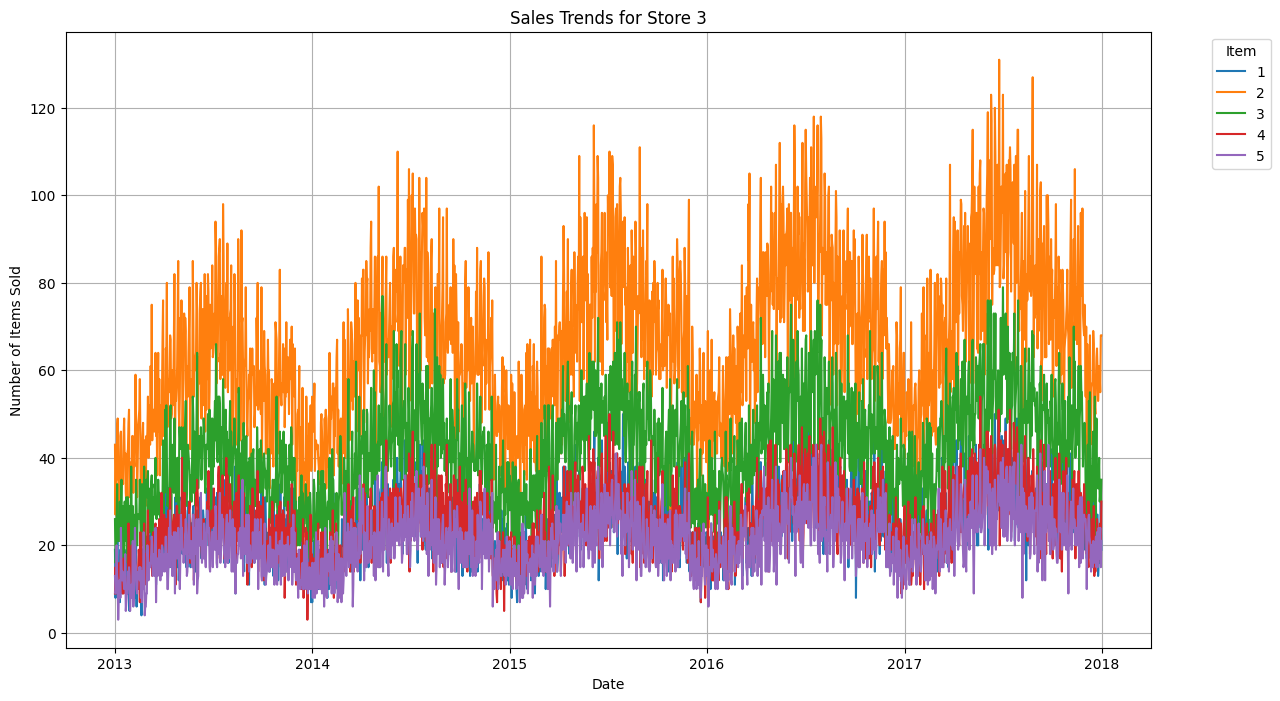

In [9]:
visualise_dateVsSales_perItem_perStore(df_train, store_number=3, item_number=[1,2,3,4,5])

# Feature Creation

In [10]:
# Extract train date features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['day_of_year'] = df_train['date'].dt.dayofyear
df_train['week_of_year'] = df_train['date'].dt.isocalendar().week

In [11]:
# Extrat test date features
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['day_of_week'] = df_test['date'].dt.dayofweek  # Monday=0, Sunday=6
df_test['day_of_year'] = df_test['date'].dt.dayofyear
df_test['week_of_year'] = df_test['date'].dt.isocalendar().week

<Axes: xlabel='month', ylabel='sales'>

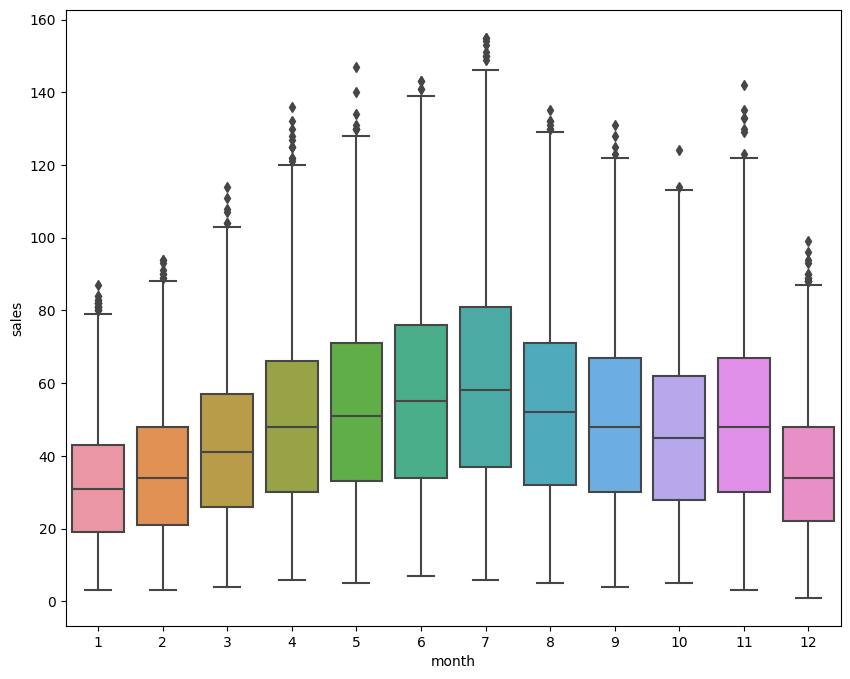

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df_train[df_train['store'] == 1], x='month', y='sales')

In [13]:
# Add lag features
for lag in [91,98,105,165,225,364,728]:
    df_train[f'sales_lag_{lag}'] = df_train['sales'].shift(lag)
    df_train[f'sales_lag_{lag}'].fillna(df_train[f'sales_lag_{lag}'].median(), inplace=True)

/tmp/ipykernel_33/2612351962.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[f'sales_lag_{lag}'].fillna(df_train[f'sales_lag_{lag}'].median(), inplace=True)
/tmp/ipykernel_33/2612351962.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

In [14]:
# Add rolling mean features

for rolling in [121,181,364]:
    df_train[f'rolling_mean_{rolling}_days'] = df_train['sales'].rolling(rolling).mean()

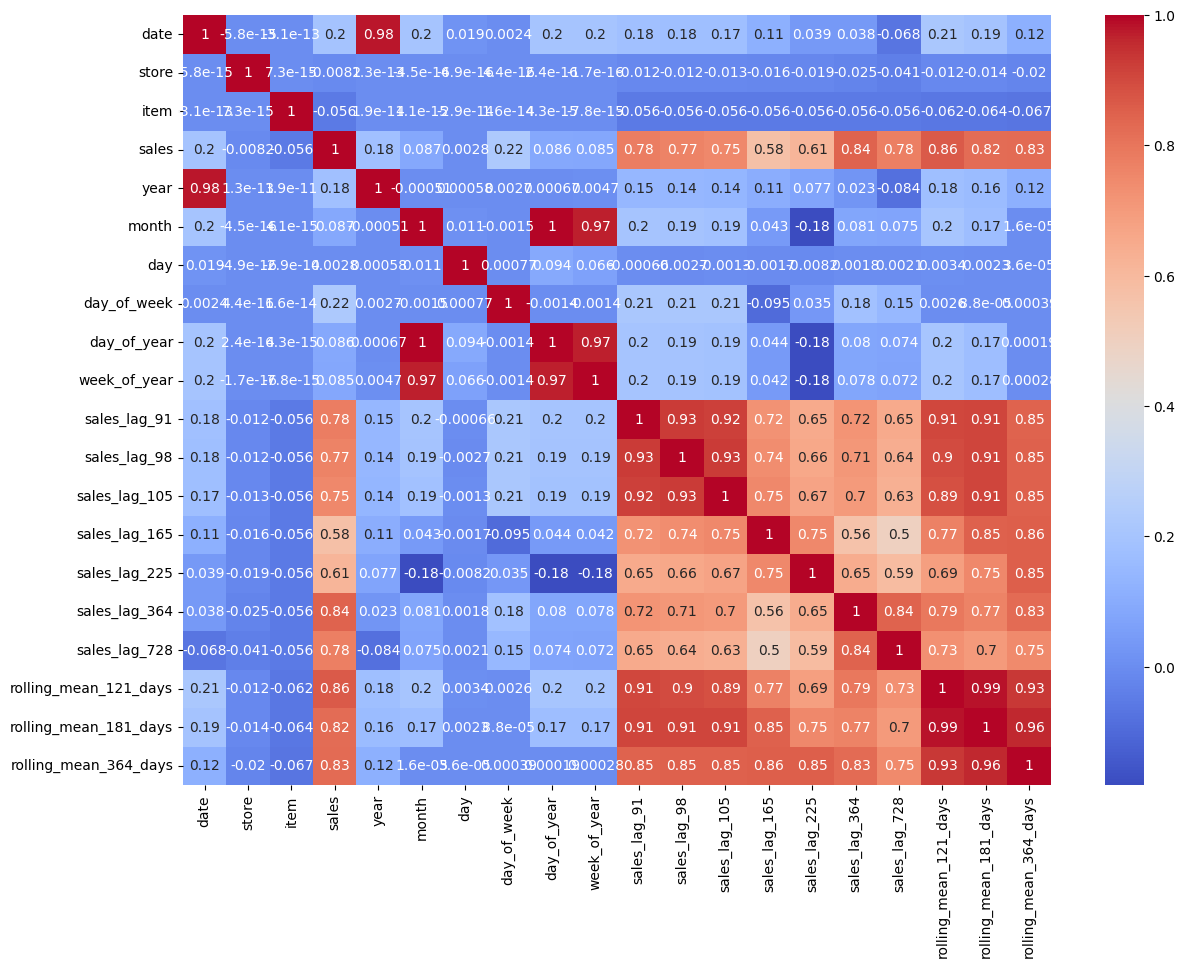

In [15]:
# Correlation matrix
plt.figure(figsize=(14, 10))
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Model Training

In [16]:
from sklearn.model_selection import train_test_split

# Prepare features and target variable for training
y_train = df_train['sales'].copy(deep=True)

X_train = df_train.drop('sales', axis=1).copy(deep=True)
X_train = X_train.drop('date', axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2,
    random_state=42
)

In [17]:
X_train = X_train.sort_index(ascending=True)
y_train = y_train.sort_index(ascending=True)

In [18]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [19]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=500,
                       early_stopping_rounds=30,
                       objective='reg:linear',
                       max_depth=10,
                       learning_rate=0.06)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=20)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:14:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:55.74954	validation_1-rmse:55.78122
[20]	validation_0-rmse:17.90188	validation_1-rmse:17.93791
[40]	validation_0-rmse:8.75266	validation_1-rmse:8.88013
[60]	validation_0-rmse:7.30982	validation_1-rmse:7.53672
[80]	validation_0-rmse:7.07582	validation_1-rmse:7.37895
[100]	validation_0-rmse:6.98365	validation_1-rmse:7.34823
[120]	validation_0-rmse:6.92244	validation_1-rmse:7.33789
[140]	validation_0-rmse:6.87013	validation_1-rmse:7.33087
[160]	validation_0-rmse:6.82598	validation_1-rmse:7.32678
[180]	validation_0-rmse:6.78619	validation_1-rmse:7.32431
[200]	validation_0-rmse:6.75055	validation_1-rmse:7.32341
[220]	validation_0-rmse:6.71503	validation_1-rmse:7.32338
[240]	validation_0-rmse:6.68696	validation_1-rmse:7.32334
[243]	validation_0-rmse:6.68192	validation_1-rmse:7.32346


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

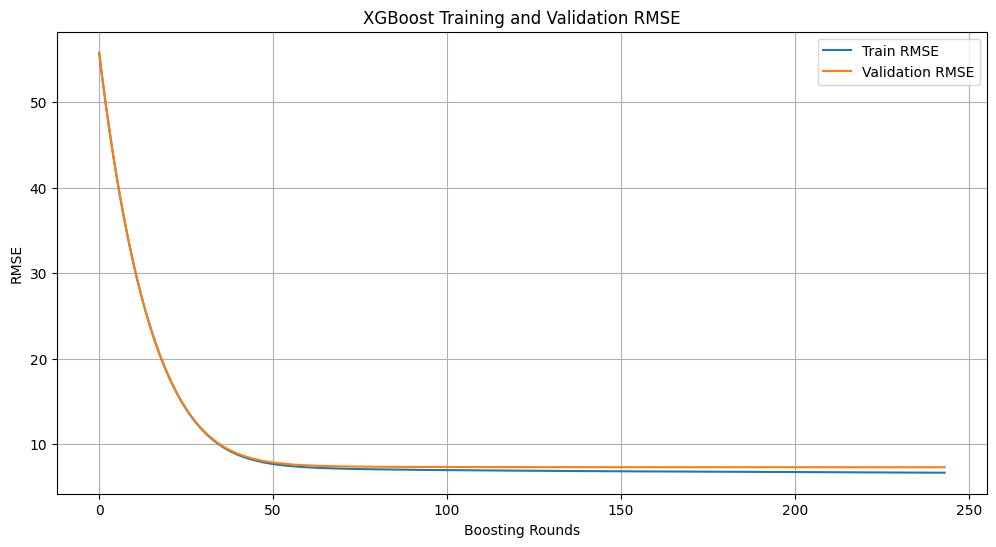

In [20]:
# Get evaluation results
evals_result = reg.evals_result()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(evals_result['validation_0']['rmse'], label='Train RMSE')
plt.plot(evals_result['validation_1']['rmse'], label='Validation RMSE')
plt.title('XGBoost Training and Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
reg.save_model('Demand_Forecast_XGBoost.json')

In [22]:
reg_load = xgb.XGBRegressor()
reg_load.load_model('Demand_Forecast_XGBoost.json')

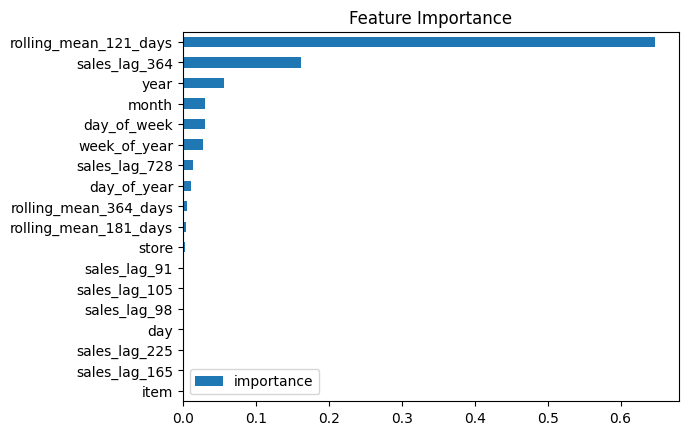

In [23]:
# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Model Forecasting

In [24]:
df_combined = pd.concat([df_train, df_test])
df_combined = df_combined.sort_values(by=['store', 'item', 'date'])
df_combined = df_combined.reset_index(drop=True)

In [25]:
df_combined

,date,store,item,sales,year,month,day,day_of_week,day_of_year,week_of_year,...,sales_lag_98,sales_lag_105,sales_lag_165,sales_lag_225,sales_lag_364,sales_lag_728,rolling_mean_121_days,rolling_mean_181_days,rolling_mean_364_days,id
0,2013-01-01,1,1,13.0,2013,1,1,1,1,1,...,47.0,47.0,47.0,47.0,47.0,47.0,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,2013,1,2,2,2,1,...,47.0,47.0,47.0,47.0,47.0,47.0,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,2013,1,3,3,3,1,...,47.0,47.0,47.0,47.0,47.0,47.0,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,2013,1,4,4,4,1,...,47.0,47.0,47.0,47.0,47.0,47.0,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,2013,1,5,5,5,1,...,47.0,47.0,47.0,47.0,47.0,47.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957995,2018-03-27,10,50,NaN,2018,3,27,1,86,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44995.0
957996,2018-03-28,10,50,NaN,2018,3,28,2,87,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44996.0
957997,2018-03-29,10,50,NaN,2018,3,29,3,88,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44997.0
957998,2018-03-30,10,50,NaN,2018,3,30,4,89,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44998.0


In [26]:
# Add lagged train features
for lag in [91,98,105,165,225,364,728]:
    df_combined[f'sales_lag_{lag}'] = df_combined['sales'].shift(lag)
    df_combined[f'sales_lag_{lag}'].fillna(df_combined[f'sales_lag_{lag}'].median(), inplace=True)

for rolling in [121,181,364]:
    df_combined[f'rolling_mean_{rolling}_days'] = df_combined.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(1).rolling(window=rolling, min_periods=10, win_type="triang").mean())

/tmp/ipykernel_33/2408257763.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined[f'sales_lag_{lag}'].fillna(df_combined[f'sales_lag_{lag}'].median(), inplace=True)
/tmp/ipykernel_33/2408257763.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [27]:
# Separate df_train and df_test after creating features
df_train_with_lags = df_combined[df_combined['date'] <= df_train['date'].max()]
df_test_with_lags = df_combined[df_combined['date'] > df_train['date'].max()]

In [28]:
df_test_with_lags = df_test_with_lags.reset_index(drop=True)
df_test_with_lags = df_test_with_lags.drop('sales', axis=1)

In [29]:
df_test_with_lags = df_test_with_lags.drop('date', axis=1)
df_test_with_lags = df_test_with_lags.drop('id', axis=1)

In [30]:
df_test_with_lags

,store,item,year,month,day,day_of_week,day_of_year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_165,sales_lag_225,sales_lag_364,sales_lag_728,rolling_mean_121_days,rolling_mean_181_days,rolling_mean_364_days
0,1,1,2018,1,1,0,1,1,12.0,14.0,22.0,37.0,25.0,15.0,12.0,21.670250,23.035382,24.414292
1,1,1,2018,1,2,1,2,1,18.0,18.0,21.0,27.0,20.0,10.0,12.0,21.625269,22.975242,24.423763
2,1,1,2018,1,3,2,3,1,15.0,27.0,20.0,35.0,15.0,16.0,16.0,21.581764,22.916284,24.433111
3,1,1,2018,1,4,3,4,1,20.0,23.0,20.0,32.0,30.0,14.0,12.0,21.540511,22.859215,24.442202
4,1,1,2018,1,5,4,5,1,19.0,28.0,28.0,27.0,22.0,24.0,12.0,21.489895,22.803772,24.450855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,10,50,2018,3,27,1,86,13,41.0,54.0,67.0,81.0,59.0,60.0,73.0,64.542042,73.175746,88.022161
44996,10,50,2018,3,28,2,87,13,63.0,51.0,67.0,97.0,90.0,73.0,68.0,64.433333,73.076652,87.944301
44997,10,50,2018,3,29,3,88,13,59.0,63.0,72.0,107.0,86.0,68.0,75.0,64.393277,72.979789,87.865829
44998,10,50,2018,3,30,4,89,13,74.0,75.0,72.0,77.0,92.0,69.0,83.0,64.367201,72.887514,87.786767


In [31]:
def smape_np(predt: np.ndarray, actual:np.ndarray)->float:
    elements = np.abs(predt-actual)/((np.abs(predt)+np.abs(actual))*0.5)
    return round(np.mean(elements)*100, ndigits=4)

In [32]:
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)

train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
val_rmse = mean_squared_error(y_val, y_pred_val, squared=False)

train_smape = smape_np(y_train,y_pred_train)
val_smape = smape_np(y_val,y_pred_val)

print(f'XGBoost Train RMSE: {train_rmse}')
print(f'XGBoost Val RMSE: {val_rmse}')

print(f'XGBoost Train SMAPE: {train_smape}')
print(f'XGBoost Val SMAPE: {val_smape}')

XGBoost Train RMSE: 6.728055558907014
XGBoost Val RMSE: 7.322941935398345
XGBoost Train SMAPE: 11.9456
XGBoost Val SMAPE: 12.6206


In [34]:
y_pred_test = reg.predict(df_test_with_lags)
X_test_with_predictions = df_test_with_lags.copy()
X_test_with_predictions['sales'] = y_pred_test

In [35]:
X_test_with_predictions['date'] = df_test['date']

In [36]:
X_test_with_predictions

,store,item,year,month,day,day_of_week,day_of_year,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_165,sales_lag_225,sales_lag_364,sales_lag_728,rolling_mean_121_days,rolling_mean_181_days,rolling_mean_364_days,sales,date
0,1,1,2018,1,1,0,1,1,12.0,14.0,22.0,37.0,25.0,15.0,12.0,21.670250,23.035382,24.414292,12.397938,2018-01-01
1,1,1,2018,1,2,1,2,1,18.0,18.0,21.0,27.0,20.0,10.0,12.0,21.625269,22.975242,24.423763,14.942825,2018-01-02
2,1,1,2018,1,3,2,3,1,15.0,27.0,20.0,35.0,15.0,16.0,16.0,21.581764,22.916284,24.433111,15.050675,2018-01-03
3,1,1,2018,1,4,3,4,1,20.0,23.0,20.0,32.0,30.0,14.0,12.0,21.540511,22.859215,24.442202,15.689685,2018-01-04
4,1,1,2018,1,5,4,5,1,19.0,28.0,28.0,27.0,22.0,24.0,12.0,21.489895,22.803772,24.450855,17.319223,2018-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,10,50,2018,3,27,1,86,13,41.0,54.0,67.0,81.0,59.0,60.0,73.0,64.542042,73.175746,88.022161,69.586670,2018-03-27
44996,10,50,2018,3,28,2,87,13,63.0,51.0,67.0,97.0,90.0,73.0,68.0,64.433333,73.076652,87.944301,72.916504,2018-03-28
44997,10,50,2018,3,29,3,88,13,59.0,63.0,72.0,107.0,86.0,68.0,75.0,64.393277,72.979789,87.865829,74.442856,2018-03-29
44998,10,50,2018,3,30,4,89,13,74.0,75.0,72.0,77.0,92.0,69.0,83.0,64.367201,72.887514,87.786767,79.512062,2018-03-30


In [37]:
df_combined_withPred = pd.concat([df_train, X_test_with_predictions])
df_combined_withPred = df_combined_withPred.sort_values(by=['store', 'item', 'date'])
df_combined_withPred = df_combined_withPred.reset_index(drop=True)

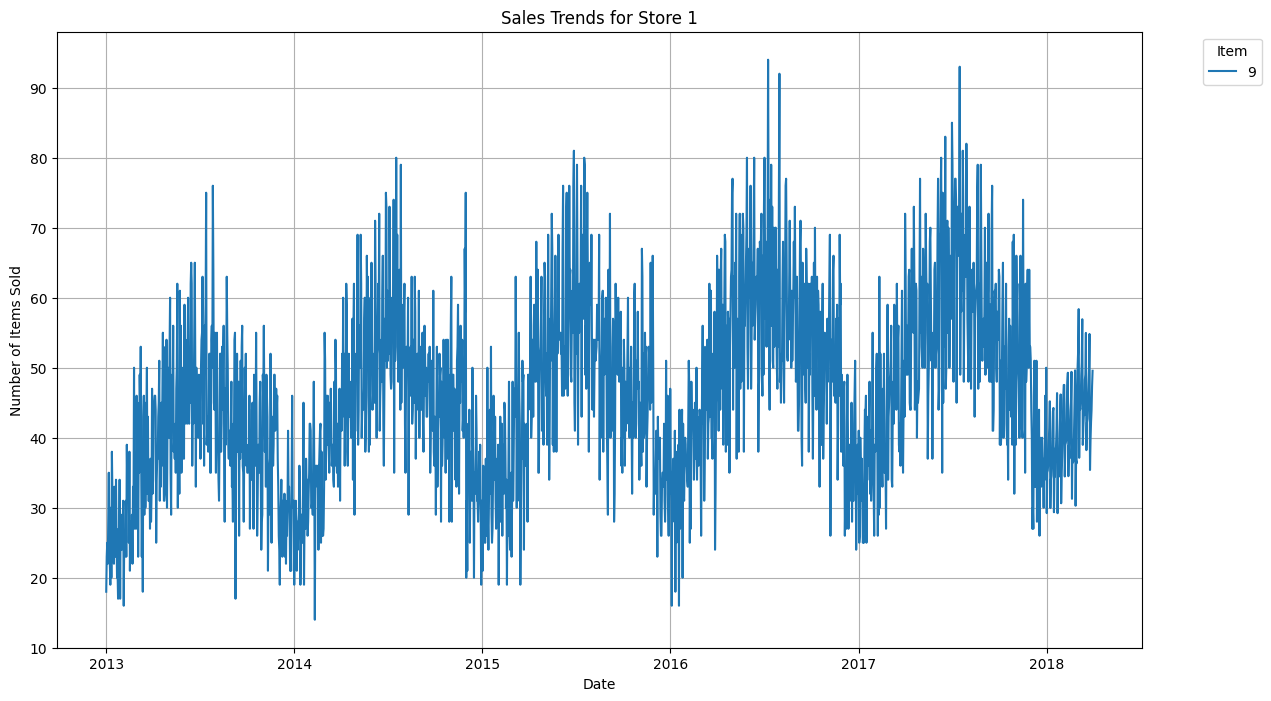

In [38]:
visualise_dateVsSales_perItem_perStore(df_combined_withPred, 1, [9])